# Asset clustering using LANL Dataset

## Table of Contents
1. Introduction
1. Load Windows Event Logs data
1. Data Aggregation by Host
1. Iterate over Clustering algorithms
1. Predict and plot results <br>


## 1. Introduction
In this tutorial, we will look at asset clustering problem. For this purpose we use the publicly available __[**Unified Host and Network Data Set**](https://csr.lanl.gov/data/2017/)__ [1] dataset from the *Advanced Research team in Cyber Systems* of the Los Alamos National Laboratory to demonstrate various aspects involved in clustering assets in a given network. Going forward, throughout this tutorial, we will refer to this dataset as *LANL dataset* and also refer to terms assets and machines interchangeably. The LANL dataset constitutes of two parts:
1. Network Event Data
1. Windows Event Logs <br>

For this tutorial we only consider the Windows Event Logs part of the dataset. The tutorial can be divided into two parts: Dataset preparation and Modelling(Clustering algorithms). 

### Dataset
In the first step, we look at pre-processing and preparation of the dataset that ultimately forms input to the clustering algorithms. We first load the raw data that contains windows event logs where each sample in the raw data is one Windows EventID being recorded by one of the machines in the network. Then we parse each of these entries and aggregate various features by each unique asset (machine) in the dataset. The output of this step is a set of assets and various numerical features computed over a period of time for these assets.

### Modeling
   In the second step, we consider KMeans and Denisty-Based Clustering algorithms. We train the prepared dataset and group the machines into different clusters using these clustering algorithms and analyze the performance iterating over a range of parameters.


[1]. M. Turcotte, A. Kent and C. Hash, “Unified Host and Network Data Set”, in Data Science for Cyber-Security. November 2018, 1-22

In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import cupy
import cudf
import cuml
import os
import bz2
import matplotlib.pyplot as plt
import sklearn.cluster
from sklearn.metrics import silhouette_score
from utils import *
from data_preprocessing import initialize_hostdf, host_aggr
from train import normalize_host_data, iterate_kmeans, get_silhouette_scores, iterate_dbscan, predict_dbscan, draw_tsne, draw_tsne_cuml, compute_chars
print("Scikit verion:{}".format(sklearn.__version__))
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Scikit verion:1.1.1


## 2. Load Windows Event Logs Data

Here, we setup the parameters required for the notebook to run. 
- **dataset_path** refers to the location where the raw windows event log files from LANL dataset are located. LANL Dataset contains 90 days worth of raw data ('wls_day-01.bz2', 'wls_day-02.bz2' etc..,), with each day corresponding to one file. 
- **ipfile_suffix** let's the user determine the range of days to be included in the dataset preparation. For e.g., *'day-01_day-10'* means 10 days' worth of data will be read and processed. 
- **op_fpath** refers to the location where the prepared dataset file should be saved, to be used later for modeling purposes.
- **read_size** refers to the size of data chunks to be read in each iteration. A parameter to trade-off speed and memory footprint

In [5]:
dataset_path = '../datasets/'
print("Sample Windows Event log files:\n{}\n".format([x for x in os.listdir(dataset_path+'wls_files/') if x.startswith('wls_')][:5]))

# Selecting date range in which the raw data files to be loaded and parsed
ipfile_suffix = 'day-01_day-01'  

#20MB chunks at a time
readsize = 20*int(1e6)
MAX_LINES = 1e7 #Loading & Processing only 10M lines from raw data for demonstration purpose.

Sample Windows Event log files:
['wls_day-02.bz2', 'wls_day-12.bz2', 'wls_day-03.bz2', 'wls_day-15.bz2', 'wls_day-14.bz2']



## 3. Data Aggregation by Host

In [6]:
def readprocess_rawdata(wls_files):
    """
    wls_files: list of windows event log files with full paths
    Given the list of raw log files, this method iterates over each file, read_size chunk
    of data at a time.
    Output is dataframe containing data aggregated by host. 
    Rows in the dataframe is the number of machines in the raw data.
    Columns correspond to the computed features.
    """
    host_, dict_, count_cols = initialize_hostdf()
    for wls_fname in wls_files:
        residue = b''
        decomp = bz2.BZ2Decompressor()
        total_lines, iter_ = 0, 0
        
        fi = open(wls_fname, 'rb')
        for data in iter(lambda: fi.read(readsize), b''):
            raw = residue + decomp.decompress(data)
            current_block = raw.split(b'\n')
            residue = current_block.pop()  # last line could be incomplete
            df_wls = read_wls(current_block, file_path=False)
            host_, dict_ = host_aggr(df_wls, host_, dict_, count_cols)
            total_lines += len(current_block)
            
            if total_lines > MAX_LINES:
                print("Breaking for loop. total_lines={}>{:d}".format(total_lines, int(MAX_LINES)))
                break
        fi.close()
        
    return host_  

As can be seen below, in day-01 data, a total of 8920 unique machines are found.

In [7]:
print("Aggregating Host machine featuress. Input= WLS files {} to {}. Read Size:{}MB".format(
    ipfile_suffix.split('_')[0], ipfile_suffix.split('_')[1], int(readsize/1e6)))
wls_files = get_fnames(dataset_path + 'wls_files/', ipfile_suffix)
host_ = readprocess_rawdata(wls_files)
print("Number of hosts:{}".format(host_.shape[0]))

opfile_suffix = '_' + ipfile_suffix
op_fname = dataset_path + 'host_agg_data{}.csv'.format(opfile_suffix)
host_.to_csv(op_fname)
print("Features computed & aggregated by Host/Asset. Output file saved to {}".format(op_fname))

Aggregating Host machine featuress. Input= WLS files day-01 to day-01. Read Size:20MB
Breaking for loop. total_lines=10905391>10000000
Number of hosts:8109
Features computed & aggregated by Host/Asset. Output file saved to ../datasets/host_agg_data_day-01_day-01.csv


<br>We now load the pre-computed aggregated dataset *host_agg_data_day-01_day-10.csv*. To generate this file, change the ipfile_suffix to *day-01_day-10* (from *day-01_day-01*) and re-run the code in above cells.<br>

**normalize_host_data()** reads the processed, aggregated host data and performs minmax scaling on each column/feature of the data. <br>
> output of normalize_host_data is tuple (df, df_norm). df is the host aggregated (but unscaled) data and df_norm is the scaled data.

In [5]:
op_fname = dataset_path + 'host_agg_data_day-01_day-10.csv'
NUM_DAYS = 10.0
df, df_norm = normalize_host_data(op_fname, norm_method='l2', preproc='minmax')
print("\nNum. Assets:{}\n".format(df_norm.shape[0]))
print("Features:\n", sorted([x for x in df_norm.columns if not x.startswith('logon_type_')]))
print("LogonType based features:\n",sorted([x for x in df_norm.columns if  x.startswith('logon_type_')]))

Num. of columns:45

REMOVED ['ActiveDirectory', 'EnterpriseAppServer'] Assets from data

Num. Assets:14044

Features:
 ['DomainName_cnt', 'Source_cnt', 'TGS_req_src_cnt', 'TGT_req_src_cnt', 'UserName_cnt', 'accnt_fail_logon_cnt', 'accnt_fail_logon_src_cnt', 'domain_ctr_validate_cnt', 'domain_ctr_validate_src_cnt', 'logon_explicit_cred_frm_cnt', 'logon_explicit_cred_to_cnt', 'scrnsaver_dismiss_cnt', 'scrnsaver_invok_cnt', 'spl_pvlgs', 'total_logins_cnt', 'total_logins_src_cnt', 'total_logoff_cnt', 'total_user_initi_logoff_cnt', 'uname_other_compacnt_login_cnt', 'uname_that_compacnt_login_cnt']
LogonType based features:
 ['logon_type_0', 'logon_type_10', 'logon_type_11', 'logon_type_12', 'logon_type_2', 'logon_type_3', 'logon_type_4', 'logon_type_5', 'logon_type_7', 'logon_type_8', 'logon_type_9', 'logon_type_frm_0', 'logon_type_frm_10', 'logon_type_frm_11', 'logon_type_frm_12', 'logon_type_frm_2', 'logon_type_frm_3', 'logon_type_frm_4', 'logon_type_frm_5', 'logon_type_frm_7', 'logon_typ




## 3. Pre-processing (Dimensionality reduction)

As can be seen from above, there a total of 48 features computed for each asset. Moreover one can inspect further and observe that the dataset is sparse. Applying the clustering algorithms directly to this will not yield successful results due to the curse of dimensionality. Therefore we need to perform dimensionality reduction without losing much information. There are many ways to achieve this and we choose Principal Component Analysis (PCA). Auto-encoding can be the other choice. We perform PCA and keep the PCA dimensions such that explained variance is 90% or more of the total variance in the data.

PCA found 13 dimensions to explain 90% of the total variance coming from 42 features in original data



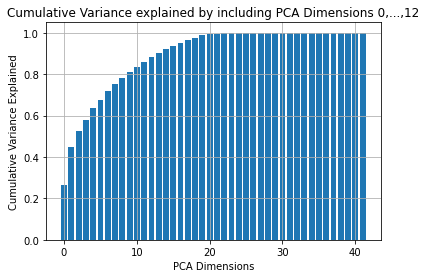

In [6]:
PCA_expl_variance = 0.9
pca = cuml.PCA(n_components=df_norm.shape[1]).fit(df_norm)
pca_dims = pca.components_.shape[0]

expl_vars = pca.explained_variance_ratio_.to_pandas().to_list()
cum_sum_vars = [sum(expl_vars[:idx+1]) for idx in range(len(expl_vars))]
pca_dims = [i for i,var in enumerate(cum_sum_vars) if var > PCA_expl_variance][0]

print("PCA found {} dimensions to explain 90% of the total variance coming from {} features in original data\n".format(
    pca_dims, df_norm.shape[1]))
plt.bar(range(len(cum_sum_vars)),cum_sum_vars)
plt.xlabel("PCA Dimensions")
plt.ylabel("Cumulative Variance Explained")
plt.grid()
plt.title("Cumulative Variance explained by including PCA Dimensions 0,...,{}".format(pca_dims-1))
plt.show()

We found 13 PCA dimensions to be enough to explain 90% of the variance in the data. The first *pca_dims* (=13 above) will be copied into a new dataframe (df_pca) which will be used going forward for all modeling purposes.

In [7]:
pca_cols = ['pca_'+str(x) for x in range(pca_dims)]
df_norm[pca_cols] = pca.transform(df_norm).iloc[:,:pca_dims]    
df_pca = df_norm[pca_cols].copy()

<br><br>
## 4.1 Iterate params for KMeans

KMeans requires number of clusters to be given as input. We iterate over the parameter "number of clusters" and observe how the inertia among the resulting clusters reduces as number of clusters increase. A good rule of thumb in choosing optimal number of clusters is when the decrease in inertia is minimal upon adding more clusters.

**Silhouette score** is another metric that can be used to arrive at optimal cluster number. Note that *Silhouette score* is used to measure the average separation distance between clusters, with values in the range [-1,+1]. The higher the Silhouette score is (approaching +1), the further away each cluster is from it's neighboring clusters.

From both the metrics/plots below, optimal nuber number of clusters appears to be between 11 & 23.

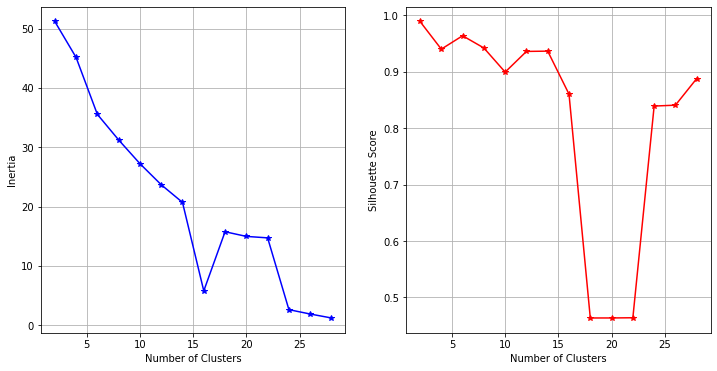

In [10]:
inertia_dict, kmeans_labels = iterate_kmeans(df_pca, verbose=False)
clusts = list(range(2,30,2))
sh_sc_dict = get_silhouette_scores(df_pca, kmeans_labels[['KMeans_'+str(x) for x in clusts]], metric='manhattan', verbose=False)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,6))
ax1.plot(inertia_dict.keys(), inertia_dict.values(), 'b*-')
ax1.set(xlabel='Number of Clusters', ylabel='Inertia')
ax1.grid(), ax2.grid()

ax2.plot(clusts, sh_sc_dict.values(), 'r*-')
ax2.set(xlabel='Number of Clusters', ylabel='Silhouette Score')
plt.show()

<br><br>
## 4.2 Iterate params for DBScan

DBSCAN, stands for Density-based Spatial Clustering of applications with noise. DBSCAN is a clustering algorithm that clusters closely packed points into one cluster based on two parameters:<br>
- $\epsilon$ denoting the maximum distance within which we two points will be considered as *"neighbors"*
- *min_samples* denoting the minimum number of samples required to be in a group before being considered to be a cluster.<br>

DBSCAN, in contrast to KMeans does not require number of clusters to be given as input. This gives the added benefit of optimal number of clusters automatically found by the algorithm itself, given the data. However we iterate over the above mentioned parameters, $\epsilon$, metric distance to consider while clustering (Euclidean distance, Manhattan distance etc..,) to arrive at the optimal choice of parameters.

In [15]:
print("Using Manhattan Distance")
clust_size, labels_db_manh = iterate_dbscan(df_pca, verbose=True)

Using Manhattan Distance
eps_value:0.0005, Found 10 clusters
eps_value:0.0050, Found 15 clusters
eps_value:0.0100, Found 15 clusters
eps_value:0.0200, Found 16 clusters
eps_value:0.0500, Found 17 clusters
eps_value:0.2500, Found 18 clusters
eps_value:0.5000, Found 18 clusters
eps_value:1.0000, Found 19 clusters
eps_value:1.5000, Found 2 clusters
eps_value:2.5000, Found 2 clusters
eps_value:5.0000, Found 1 clusters


In [16]:
print("\nUsing Minkowski distance, p=1/2 ")
clust_size_phalf, labels_db_minkhalf = iterate_dbscan(df_pca, metric_p=0.5, verbose=True)


Using Minkowski distance, p=1/2 
eps_value:0.0005, Found 10 clusters
eps_value:0.0050, Found 15 clusters
eps_value:0.0100, Found 15 clusters
eps_value:0.0200, Found 16 clusters
eps_value:0.0500, Found 17 clusters
eps_value:0.2500, Found 18 clusters
eps_value:0.5000, Found 18 clusters
eps_value:1.0000, Found 19 clusters
eps_value:1.5000, Found 2 clusters
eps_value:2.5000, Found 2 clusters
eps_value:5.0000, Found 1 clusters


- For values of $\epsilon \geq  1.5$ the number of clusters drops down drastically from 19 to 2, thus indicating that no reliable clustering is happening. 
- However, for $0.0005 \leq \epsilon \leq 1.0$ the number of clusters increase gradually from 10 to 19 as $\epsilon$ increases.<br>
The above conclusions hold true either for **Manhattan distance ($p=1$) or Minkowski distance with $p=\frac{1}{2}$**, as can be seen above. 


Therefore, we need to anlyze the clusters and their inertia, cluster sizes etc.., **for values between $0.0005 \leq \epsilon \leq 1.0$** to determine optimal value.

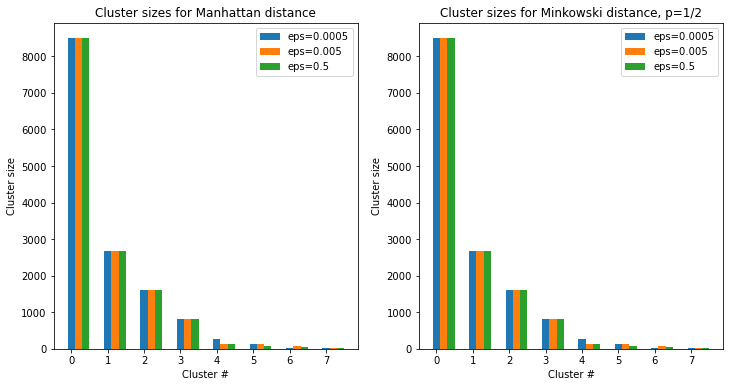

96.79% of assets are in Top 4 clusters
99.88% of assets are in Top 8 clusters


In [27]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,6))
eps_vals = [0.0005, 0.005, 0.5]

X_axis = np.arange(8)
for idx, eps_ in enumerate(eps_vals):
    ax1.bar(X_axis + 0.2*idx, clust_size[eps_].iloc[:8].to_arrow(), 0.2, label = 'eps='+str(eps_))
ax1.set_title("Cluster sizes for Manhattan distance")
ax1.set(xlabel="Cluster #", ylabel="Cluster size")
ax1.legend()

for idx, eps_ in enumerate(eps_vals):
    ax2.bar(X_axis + 0.2*idx, clust_size_phalf[eps_].iloc[:8].to_arrow(), 0.2, label = 'eps='+str(eps_))
ax2.set_title("Cluster sizes for Minkowski distance, p=1/2")
ax2.set(xlabel="Cluster #",ylabel="Cluster size")
ax2.legend()
plt.show()
print("{:.2f}% of assets are in Top 4 clusters".format(100*clust_size[0.0005].iloc[:4].sum()/clust_size[0.0005].sum()))
print("{:.2f}% of assets are in Top 8 clusters".format(100*clust_size[0.0005].iloc[:8].sum()/clust_size[0.0005].sum()))

As can be seen from the results above, the cluster sizes for the top 8 clusters are almost identical for a range of $\epsilon$ i.e, $\epsilon \in (0.0005, 0.005, 0.5)$. Also note that these 8 clusters together account for 99.92% of all assets in the dataset. This indicates that for all practical purposes, **any of these three $\epsilon$ values are providing the same clustering for almost all the data**. We can further verify that claim below.

In [19]:
top_4_clusts = labels_db_manh.loc[(labels_db_manh['eps_0.0005'].isin([0,1,2,3])) | (labels_db_manh['eps_0.005'].isin([0,1,2,3]))]
mismatch = top_4_clusts.loc[top_4_clusts['eps_0.0005'] != top_4_clusts['eps_0.005']]
print("Found {}/{} assets in top 4 clusters of either eps values".format(top_4_clusts.shape[0], labels_db_manh.shape[0]))
print("Among top 4 clusters, between eps=0.0005 & 0.005, found {} assets belonging to different clusters".format(mismatch.shape[0]))

Found 13593/14044 assets in top 4 clusters of either eps values
Among top 4 clusters, between eps=0.0005 & 0.005, found 0 assets belonging to different clusters


We can further look at Silhouette score, as we did for KMeans, for different values of $\epsilon$ and choice of metric distance.

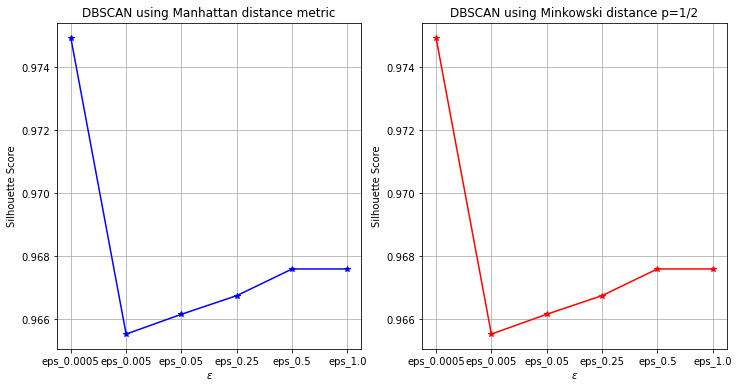

In [41]:
eps_vals = [0.0005, 0.005, 0.05, 0.25, 0.5, 1.0]
sh_sc_dict1 = get_silhouette_scores(df_pca, labels_db_manh[['eps_'+str(x) for x in eps_vals]], metric='manhattan', verbose=False)
sh_sc_dicthalf = get_silhouette_scores(df_pca, labels_db_minkhalf[['eps_'+str(x) for x in eps_vals]], metric='manhattan', verbose=False)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,6))
ax1.plot(sh_sc_dict1.keys(), sh_sc_dict1.values(), 'b*-')
ax1.set(xlabel='$\epsilon$', ylabel='Silhouette Score', title='DBSCAN using Manhattan distance metric')
ax1.grid(), ax2.grid()

ax2.plot(sh_sc_dicthalf.keys(), sh_sc_dicthalf.values(), 'r*-')
ax2.set(xlabel='$\epsilon$', ylabel='Silhouette Score', title='DBSCAN using Minkowski distance p=1/2')
plt.show()

From the above plots,
- Silhouette score remained *almost* constant for $0.0005 \leq \epsilon \leq 1.0$. This is in line with what we have seen earlier i.e., the clustering for 99.9% of the data is identical.
- If you observe the y-axis, the Silhouette score is highest for $\epsilon=0.0005$. It's fairly constant as we change $\epsilon$ from 0.005 to 0.25. Thus indicating that for larger values of $\epsilon$, the algorithm is achieving slightly lower spearation between clusters. 

**Conclusions:**<br>From the above observations so far, we can conclude that, for a range of $ \epsilon \in(0.0005, 0.005,0.05, 0.25, 0.5) $ and for the choice of distance metric among Manhattan or Minkowski($p=1/2$) distances:
- The cluster sizes for top few clusters  for the clustering result remains stable and
- The average silhouette distance value remains fairly constant at approximately 0.970. Please note that the maximum value Silhouette score can take is +1.

**Comparison with KMeans:**<br>Also if we want to compare between KMeans and DBSCAN, let's compare Silhouette scores for equal number of clusters. 
1. DBSCAN, Manhattan Distance, $\epsilon=0.0005$: 9 Clusters with Silhouette score of 0.974.
1. KMeans, Manhattan Distance, 9 clusters: Silhouette score of 0.850.
Thus indicating that **DBSCAN is a more optimal clustering algorithm** for this dataset, in comparison to KMeans.

So in conclusion, we choose DBSCAN to be our clustering algorithm with $\epsilon=0.0005$, Manhattan distance(Minkowski parameter p=1) for distance metric. 

<br><br>
## 4.3 Clustering results using DBScan and optimal parameters

We perform the dbscan fit using the parameters described above.

In [8]:
df, dbscmodel = predict_dbscan(df, df_pca,  eps_=0.0005, metric_p=1)
clust_ = 'cluster_dbscan_eps0.0005_minkp1'
print("Cluster sizes:\n{}".format(df[clust_].value_counts()))
print("Num. of features seen during fit:{}".format(dbscmodel.n_features_in_))

Cluster sizes:
 0    8498
 2    2678
 1    1611
 3     806
-1     260
 4     121
 5      27
 7      26
 8       9
 6       8
Name: cluster_dbscan_eps0.0005_minkp1, dtype: int32
Num. of features seen during fit:13


### 4.3.1 SNE based visualization of clusters in 2-dimensions.

In [34]:
def tsneplot_util(df_, tsne_cols, color_map, title):
    tsne1, tsne2 = tsne_cols[0], tsne_cols[1]
    df['color']='k'
    for k,v  in color_map.items(): 
        df_.loc[df_[clust_]==k,'color']=v
    scatter = plt.scatter(tsne1, tsne2, c='color', data=df_)
    plt.xlabel('tSNE1')
    plt.ylabel('tSNE2')
    plt.title(title)

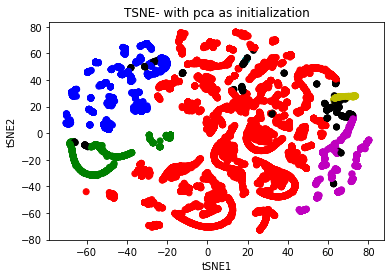

In [61]:
initialization = 'pca'
df_tsne = draw_tsne(df_pca.to_pandas(),init=initialization)

df[['tsne_1','tsne_2']] = df_tsne
color_map = {0:'r', 1:'b', 2:'g', 3:'m', 4:'y', 5:'c', 6:'w'}
tsneplot_util(df.to_pandas(), ('tsne_1','tsne_2'), color_map, title='TSNE- with pca as initialization')

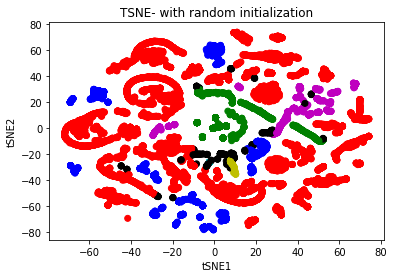

In [63]:
initialization = 'random'
cols_tsne = [x for x in df_norm.columns if 'pca_' not in x]
df_tsne = draw_tsne(df_pca.to_pandas(), init=initialization)
df[['tsne_1','tsne_2']] = df_tsne

color_map = {0:'r', 1:'b', 2:'g', 3:'m', 4:'y', 5:'c', 6:'w'}
tsneplot_util(df.to_pandas(), ('tsne_1','tsne_2'), color_map, title='TSNE- with random initialization')

<br><br>
## 5. Conclusion 

In this section, we will look to analyze the resulting clusters and tease out any distinguishing chracteristics of the clusters.

We will used the method compute_chars() from model module. This function, for a given cluster=couster_id, computes statistcis for each feature and prints the features with highest amount of deviation compared to rest of the clusters

In [9]:
cluster_chars = compute_chars(df, clust_, cluster_id=0, NUM_DAYS=NUM_DAYS, verbose=False)

/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/series.py:3179: FutureWarning: Series.merge is deprecated and will be removed in a future release. Use cudf.merge instead.
  warnings.warn(



CLUSTER:0, Size:8498
Features with Top differences:
uname_that_compacnt_login_frac_mean_dev    1.000000
logon_type_frm_2_mean_dev                  0.999926
logon_type_2_mean_dev                      0.999903
uname_other_compacnt_login_cnt_mean_dev    0.999859
logon_type_9_mean_dev                      0.999760
uname_that_compacnt_login_cnt_mean_dev     0.999695
TGT_req_src_cnt_mean_dev                   0.999192
logon_type_3_mean_dev                      0.998422
total_logoff_cnt_mean_dev                  0.998321
total_logins_cnt_mean_dev                  0.998205
Name: 0, dtype: float64



Let's look at the top feature *uname_that_compacnt_login_frac* and analyze it for statistical differences between different clusters.

In [13]:
col = 'uname_that_compacnt_login_frac'
coldf = df.dropna(axis=0, subset=[col])
col_clust0, col_clustrest = coldf.loc[coldf[clust_] == 0, col], coldf.loc[coldf[clust_] != 0, col]

clust0_hist, clust0_vals = np.histogram(col_clust0, bins=5, range=(0,1))
clustrem_hist, clustrem_vals =  np.histogram(col_clustrest, bins=5, range=(0,1)) 

clust0_hist, clustrem_hist = 100*clust0_hist/col_clust0.shape[0], 100*clustrem_hist/col_clustrest.shape[0]
clust0_hist, clustrem_hist = cupy.asnumpy(clust0_hist), cupy.asnumpy(clustrem_hist)


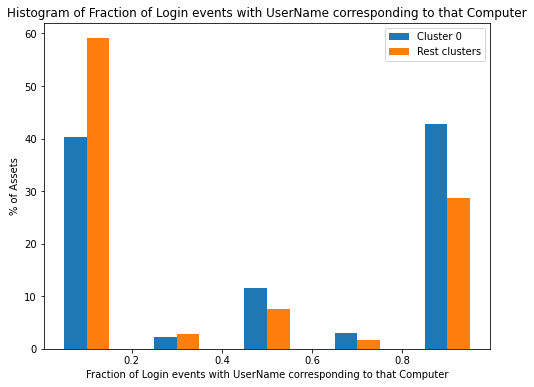

In [15]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
bins=np.linspace(0.1,0.9,5)
ax.bar(bins-0.025, clust0_hist, width=0.05, label='Cluster 0') 
ax.bar(bins+0.025, clustrem_hist, width=0.05, label='Rest clusters') 
ax.set_title("Histogram of Fraction of Login events with UserName corresponding to that Computer")
ax.set(xlabel="Fraction of Login events with UserName corresponding to that Computer", ylabel="% of Assets")
ax.legend()

**How to read**: 
Consider for e.g., last two bars, corresponding to the bin $ [0.8, 1] $:
- In Cluster 0, **for $ 48 \% $ of assets**, more than 0.9 (90%) of Login Events have initiated from UserName corresponding to that computer.
- In Remaining Clusters, **for only $ 31 \% $ of assets**, more than 0.9 (90%) of Login Events have initiated from UserName corresponding to that computer.
<br><br>

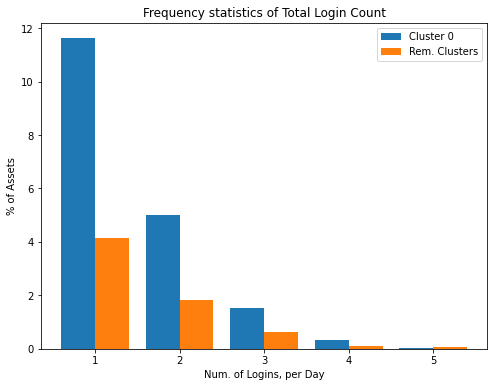

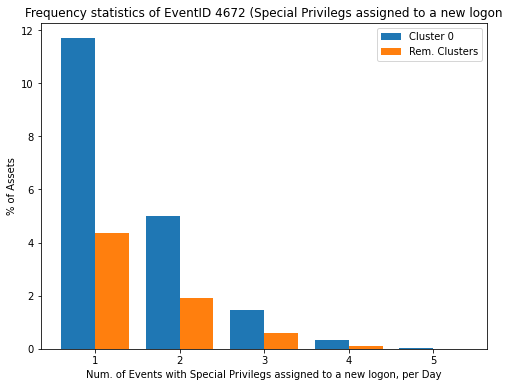

In [55]:
def plot_util(freqs, col, rows, title, xaxis, yaxis):
    fig, ax = plt.subplots(1,1, figsize=(8,6))
    _ = plt.bar(freqs.iloc[1:rows].index-0.2, freqs.iloc[1:rows][col+'_x'], label='Cluster 0', width=0.4) 
    _ =plt.bar(freqs.iloc[1:rows].index+0.2, freqs.iloc[1:rows][col+'_y'], label='Rem. Clusters', width=0.4) 
    ax.set(title=title)
    ax.set(xlabel=xaxis, ylabel=yaxis)
    plt.legend()
    return

pddf = df.to_pandas()
titles=["Frequency statistics of Total Login Count", "Frequency statistics of EventID 4672 (Special Privilegs assigned to a new logon"]
xaxes = ["Num. of Logins, per Day", "Num. of Events with Special Privilegs assigned to a new logon, per Day"]
yaxis = "% of Assets"
for i, col in enumerate(['total_logins_cnt', 'spl_pvlgs']):
    freqs = compute_val_counts(pddf, col=col, clust_=clust_)
    plot_util(freqs, col, rows=6, title=titles[i], xaxis=xaxes[i], yaxis=yaxis)

Assets with zero 4672 EventIDs are excluded from above bar chart. 
- 81% of Assets in *Cluster 0* have 0 EventID=4672 events. 
- 91% of Assets in *remaining clusters* have 0 EventID=4672 events.

Note that Cluster 0 has **higher EventID 4672 occurence** compared to remaining clusters. For e.g., **in Cluster 0, $19\%$ of assets have $\geq 1$** 4672Event per day on average whereas the corresponding proportion is **only $9\%$ for remaining data.**

<br><br>In conclusion, assets in Cluster 0, when compared to remaining clusters, have:
- Higher number of Login events (EventID 4624 & 4625)
- Similarly high number of *Special privileges assigned to a new logon* events (EventID 4672)
